### Carregamento e Integração dos Dados

Inicialmente, o diretório `/home/jovyan/work` é adicionado ao caminho de busca do Python, viabilizando a importação de módulos utilitários desenvolvidos para o projeto. Em seguida, utiliza-se a classe `DataLoader`, do pacote `utils`, para realizar a leitura dos arquivos CSV referentes às ocorrências de acidentes e às pessoas envolvidas, armazenados em subdiretórios distintos.

Os dados carregados são integrados por meio de uma junção (`join`) baseada na coluna `id`, resultando em um `DataFrame` consolidado (`df_joined`) que reúne informações tanto das ocorrências quanto dos envolvidos, servindo como base para as análises posteriores.

In [1]:
import sys
sys.path.append("/home/jovyan/work")

from utils.dataloader import DataLoader
from utils.workload import Workload

# Instancia o DataLoader para ocorrências
ocorrencias_loader = DataLoader(base_dir="/home/jovyan/work/full_data/ocorrencias")
df_ocorrencias = ocorrencias_loader.load()

# Instancia o DataLoader para pessoas
pessoas_loader = DataLoader(base_dir="/home/jovyan/work/full_data/pessoas")
df_pessoas = pessoas_loader.load()

# Realiza o join entre os dois DataFrames com base na coluna 'id'
df_joined = DataLoader.join(df_ocorrencias, df_pessoas, on=["id"], how="inner")

### Distribuição Etária dos Envolvidos em Acidentes de Trânsito

O código tem por objetivo realizar uma análise quantitativa da distribuição de indivíduos envolvidos em acidentes de trânsito, segmentando-os por faixas etárias. Inicialmente, é definida uma função que recebe um `DataFrame` do PySpark e cria uma nova coluna denominada `faixa_etaria`, a partir da classificação da variável `idade` em intervalos predefinidos: menores de 18 anos (`<18`), de 18 a 29 anos (`18–29`), de 30 a 44 anos (`30–44`), de 45 a 59 anos (`45–59`) e 60 anos ou mais (`60+`).

A seguir, o conjunto de dados é agregado com base nessas faixas etárias, contabilizando o número de registros em cada grupo. Os resultados são convertidos para um `DataFrame` do pandas com o intuito de gerar uma visualização gráfica por meio de um gráfico de barras, que apresenta de forma clara a distribuição dos envolvidos por faixa etária. A função é encapsulada em uma `Workload`, permitindo sua integração no fluxo analítico do projeto, favorecendo a modularização, reutilização e padronização das análises executadas.


[WORKLOAD-1] Analisa o número de envolvidos em acidentes por faixa etária (Distribuição por Faixa Etária)
[VERIFICAÇÃO] Total no gráfico: 4510068
[VERIFICAÇÃO] Total de pessoas: 4510068


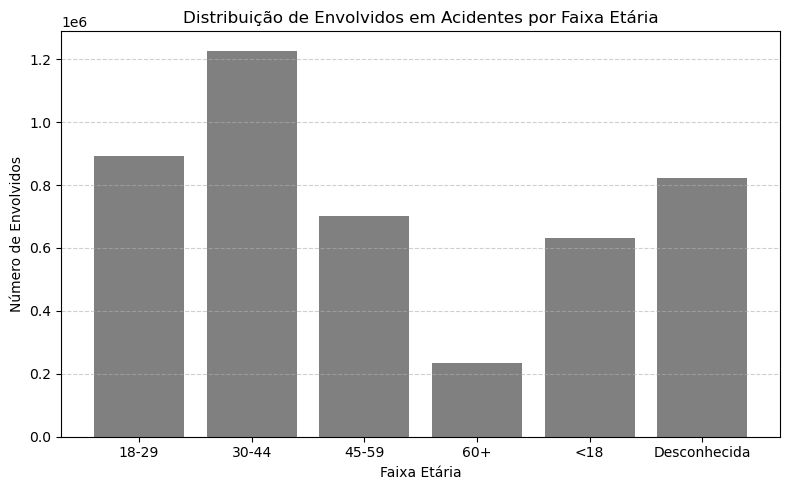

[METRIC] Tempo de execução (Distribuição por Faixa Etária): 12.29 segundos


In [2]:
from utils.workload import Workload
from pyspark.sql.functions import col, when

def analise_faixa_etaria(df):
    import matplotlib.pyplot as plt

    # Cria coluna de faixa etária
    df = df.withColumn(
        "faixa_etaria",
        when(col("idade") < 18, "<18")
        .when((col("idade") >= 18) & (col("idade") < 30), "18-29")
        .when((col("idade") >= 30) & (col("idade") < 45), "30-44")
        .when((col("idade") >= 45) & (col("idade") < 60), "45-59")
        .when(col("idade") >= 60, "60+")
        .otherwise("Desconhecida")
    )

    # Agrupa por faixa etária
    resultado = df.groupBy("faixa_etaria").count().orderBy("faixa_etaria").toPandas()
    # Verificação
    total_grafico = resultado["count"].sum()
    total_pessoas = df.select("pesid").count()
    print(f"[VERIFICAÇÃO] Total no gráfico: {total_grafico}")
    print(f"[VERIFICAÇÃO] Total de pessoas: {total_pessoas}")
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.bar(resultado["faixa_etaria"], resultado["count"], color='gray')
    plt.xlabel("Faixa Etária")
    plt.ylabel("Número de Envolvidos")
    plt.title("Distribuição de Envolvidos em Acidentes por Faixa Etária")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Criação da workload
workload_faixa_etaria = Workload(
    name="Distribuição por Faixa Etária",
    description="[WORKLOAD-1] Analisa o número de envolvidos em acidentes por faixa etária",
    execute_fn=analise_faixa_etaria
)

# Execução da workload
workload_faixa_etaria.run(df_pessoas)

### Análise Temporal de Acidentes: Distribuição por Hora do Dia

A análise de distribuição de acidentes por hora do dia tem como objetivo identificar a frequência com que os acidentes de trânsito ocorrem ao longo das 24 horas do dia. Esta análise é realizada com base no campo `horario` presente na base de dados consolidada de acidentes, que inclui registros de diversos anos.

Para isso, foi definida uma carga de trabalho (`Workload`) que utiliza PySpark para realizar a transformação dos dados, extraindo a hora de cada ocorrência e agrupando os registros por esse valor. O número de acidentes por hora é então contado e ordenado para facilitar a interpretação.

Após a etapa de processamento, os resultados são convertidos para um DataFrame pandas, permitindo a geração de um gráfico de barras com a biblioteca Matplotlib. Esse gráfico ilustra visualmente como os acidentes se distribuem ao longo do dia, possibilitando a identificação de faixas horárias com maior ou menor incidência de ocorrências.

In [3]:
from pyspark.sql.functions import hour, col, count, year
import matplotlib.pyplot as plt
import pandas as pd

def analise_distribuicao_temporal(df, tipo="hora"):
    """
    Realiza a análise da distribuição temporal de acidentes de trânsito,
    permitindo agrupar os dados por hora do dia, dia da semana ou ano.

    Parâmetros:
    - df (DataFrame): DataFrame contendo os dados de ocorrências.
    - tipo (str): Tipo de agrupamento temporal. Pode ser 'hora', 'semana' ou 'ano'.
    """

    if tipo == "hora":
        df_temp = df.withColumn("tempo", hour("horario"))
        titulo = "Distribuição de Acidentes por Hora do Dia"
        eixo_x = "Hora"
    elif tipo == "semana":
        df_temp = df.withColumn("tempo", col("dia_semana"))
        titulo = "Distribuição de Acidentes por Dia da Semana"
        eixo_x = "Dia da Semana"
    elif tipo == "ano":
        df_temp = df.withColumn("tempo", year(col("data_inversa")))
        titulo = "Distribuição de Acidentes por Ano"
        eixo_x = "Ano"
    else:
        raise ValueError("O parâmetro 'tipo' deve ser 'hora', 'semana' ou 'ano'.")

    # Agrupa e converte para pandas
    resultado = df_temp.groupBy("tempo").agg(count("*").alias("total")).orderBy("tempo").toPandas()

    # Ordenação dos dias da semana, se necessário
    if tipo == "semana":
        ordem_dias = [
            "segunda-feira", "terça-feira", "quarta-feira",
            "quinta-feira", "sexta-feira", "sábado", "domingo"
        ]
        resultado["tempo"] = pd.Categorical(resultado["tempo"], categories=ordem_dias, ordered=True)
        resultado = resultado.sort_values("tempo")

    # Geração do gráfico
    plt.figure(figsize=(9, 5))
    plt.bar(resultado["tempo"], resultado["total"], color="gray")
    plt.xlabel(eixo_x)
    plt.ylabel("Número de Acidentes")
    plt.title(titulo)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    if tipo == "ano":
        plt.xticks(resultado["tempo"][::1], rotation=45)
    plt.tight_layout()
    plt.show()

[WORKLOAD-3] Análise Temporal de Acidentes: Distribuição por Hora do Dia (Distribuição Temporal por Hora do Dia)


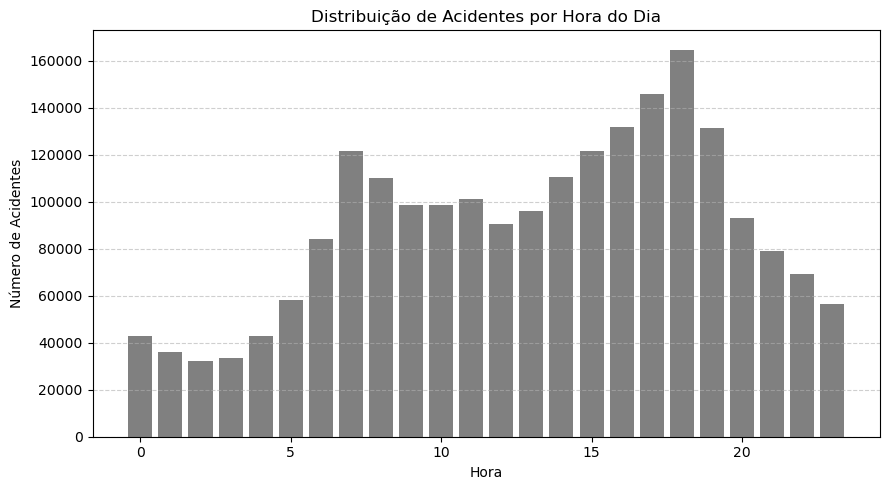

[METRIC] Tempo de execução (Distribuição Temporal por Hora do Dia): 2.37 segundos


In [4]:
from utils.workload import Workload

# Cria uma workload para distribuição por hora
workload_temporal_hora = Workload(
    name="Distribuição Temporal por Hora do Dia",
    description="[WORKLOAD-3] Análise Temporal de Acidentes: Distribuição por Hora do Dia",
    execute_fn=lambda df: analise_distribuicao_temporal(df, tipo="hora")
)

workload_temporal_hora.run(df_ocorrencias)

[WORKLOAD-4] Análise Temporal de Acidentes: Distribuição por Dia da Semana (Distribuição Temporal por Dia da Semana)


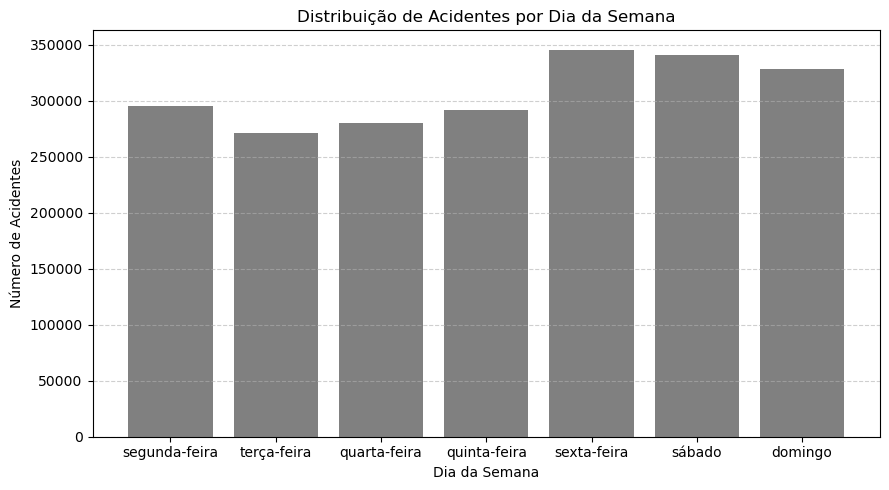

[METRIC] Tempo de execução (Distribuição Temporal por Dia da Semana): 2.15 segundos


In [5]:
from utils.workload import Workload

# Cria uma workload para distribuição por dia da semana
workload_temporal_hora = Workload(
    name="Distribuição Temporal por Dia da Semana",
    description="[WORKLOAD-4] Análise Temporal de Acidentes: Distribuição por Dia da Semana",
    execute_fn=lambda df: analise_distribuicao_temporal(df, tipo="semana")
)

workload_temporal_hora.run(df_ocorrencias)

[WORKLOAD-4] Análise Temporal de Acidentes: Distribuição por Ano (Distribuição Temporal por Ano)


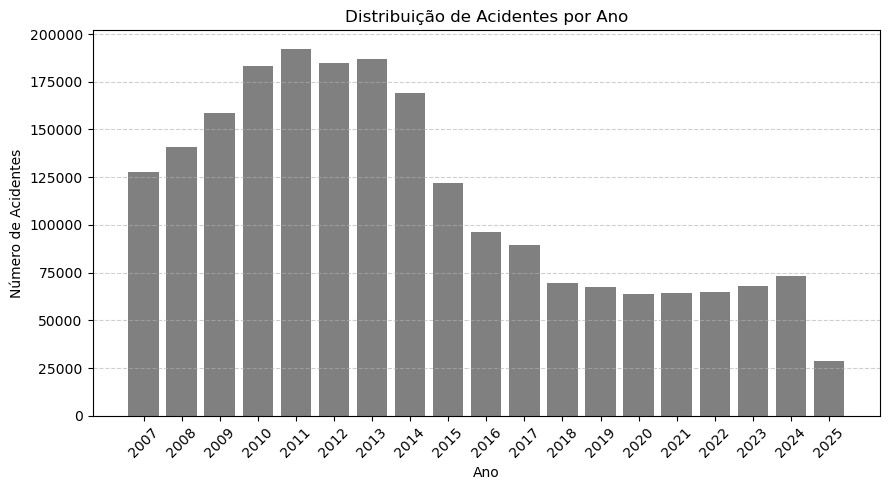

[METRIC] Tempo de execução (Distribuição Temporal por Ano): 2.18 segundos


In [6]:
from utils.workload import Workload

# Cria uma workload para distribuição por ano
workload_temporal_hora = Workload(
    name="Distribuição Temporal por Ano",
    description="[WORKLOAD-4] Análise Temporal de Acidentes: Distribuição por Ano",
    execute_fn=lambda df: analise_distribuicao_temporal(df, tipo="ano")
)

workload_temporal_hora.run(df_ocorrencias)